<a href="https://colab.research.google.com/github/mohmadAyman75/Face-classification/blob/main/FINAL_VGG16_50Classes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
import re
import json
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

from sklearn.model_selection import train_test_split


Mounted at /content/drive


In [ ]:
!ls "/content/drive/MyDrive/Final_data"

train  train-20251212T212831Z-1-001.zip  val  val-20251212T224639Z-1-001.zip


In [ ]:
import zipfile
import os

base_path = "/content/drive/MyDrive/Final_data"

zip_train = os.path.join(base_path, "train-20251212T212831Z-1-001.zip")
zip_val   = os.path.join(base_path, "val-20251212T224639Z-1-001.zip")

extract_train = os.path.join(base_path, "train")
extract_val   = os.path.join(base_path, "val")

# فك ضغط train
if not os.path.exists(extract_train):
    with zipfile.ZipFile(zip_train, 'r') as zip_ref:
        zip_ref.extractall(extract_train)

# فك ضغط val
if not os.path.exists(extract_val):
    with zipfile.ZipFile(zip_val, 'r') as zip_ref:
        zip_ref.extractall(extract_val)

print("Unzip done")


Unzip done


In [ ]:
print(os.listdir("/content/drive/MyDrive/Final_data"))
print(os.listdir("/content/drive/MyDrive/Final_data/train"))
print(os.listdir("/content/drive/MyDrive/Final_data/val"))


['train-20251212T212831Z-1-001.zip', 'val-20251212T224639Z-1-001.zip', 'train', 'val']
['train']
['val']


In [ ]:
train_path_data = "/content/drive/MyDrive/Final_data/train/train"
val_path_data   = "/content/drive/MyDrive/Final_data/val/val"


In [ ]:
print(os.listdir(train_path_data)[:5])
print(os.listdir(val_path_data)[:5])


['n000437', 'Mohamed_eissa', '1Mohmad-Ayman-Suleiman', 'n000479', 'n000433']
['n001125', 'n000836', 'n001197', 'n001021', 'n000774']


In [ ]:
def natural_sort_key(text):
    return [int(c) if c.isdigit() else c for c in re.split(r'(\d+)', text)]

def generate_df(dir_path, limit_per_class=None):
    image_path = []
    image_label = []

    for label in sorted(os.listdir(dir_path), key=natural_sort_key):
        label_path = os.path.join(dir_path, label)
        if not os.path.isdir(label_path):
            continue

        images = sorted(os.listdir(label_path), key=natural_sort_key)
        if limit_per_class:
            images = images[:limit_per_class]

        for img in images:
            full_path = os.path.join(label_path, img)
            if os.path.isfile(full_path):
                image_path.append(full_path)
                image_label.append(label)

    return pd.DataFrame({
        "image_path": image_path,
        "label": image_label
    })


In [ ]:
train_df = generate_df(train_path_data, limit_per_class=50)
val_df   = generate_df(val_path_data, limit_per_class=50)

train_df = pd.concat([train_df, val_df], ignore_index=True).reset_index(drop=True)
MAX_CLASSES = 50
selected_labels = sorted(train_df['label'].unique())[:MAX_CLASSES]
train_df = train_df[train_df['label'].isin(selected_labels)].reset_index(drop=True)

class_idx = {label: i for i, label in enumerate(sorted(train_df['label'].unique()))}
train_df['label_'] = train_df['label'].map(class_idx)

NUM_CLASSES = train_df['label_'].nunique()
print("Num of classes:", NUM_CLASSES)
with open("class mapping.json", "w") as f:
    json.dump({v: k for k, v in class_idx.items()}, f)


Num of classes: 50


In [ ]:
train_df_split, val_df_split = train_test_split(
    train_df,
    test_size=0.2,
    stratify=train_df['label_'],
    random_state=42
)

train_df_split['label_'] = train_df_split['label_'].astype(str)
val_df_split['label_']   = val_df_split['label_'].astype(str)

print(len(train_df_split), len(val_df_split))


2000 500


In [ ]:
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 64
EPOCHS = 45

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.15,
    brightness_range=[0.7, 1.3],
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_dataframe(
    train_df_split,
    x_col='image_path',
    y_col='label_',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    shuffle=True
)

validation_generator = val_datagen.flow_from_dataframe(
    val_df_split,
    x_col='image_path',
    y_col='label_',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    shuffle=False
)


Found 1997 validated image filenames belonging to 50 classes.
Found 499 validated image filenames belonging to 50 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 3 invalid image filename(s) in x_col="image_path". These filename(s) will be ignored.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 1 invalid image filename(s) in x_col="image_path". These filename(s) will be ignored.
  warnings.warn(


In [ ]:
base_model = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

for layer in base_model.layers:
    layer.trainable = False

x = GlobalAveragePooling2D()(base_model.output)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(NUM_CLASSES, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 50)             │        51,250 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,291,250 (58.33 MB)

 Trainable params: 576,562 (2.20 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    verbose=1,
    min_lr=1e-7
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=7,
    restore_best_weights=True,
    verbose=1
)

checkpoint = ModelCheckpoint(
    filepath='best_vgg16_model.h5',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)

history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    callbacks=[reduce_lr, early_stop, checkpoint]
)



/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/45
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 21s/step - accuracy: 0.0246 - loss: 7.2589 
Epoch 1: val_loss improved from inf to 4.33000, saving model to best_vgg16_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 881s 27s/step - accuracy: 0.0246 - loss: 7.2457 - val_accuracy: 0.0641 - val_loss: 4.3300 - learning_rate: 1.0000e-04
Epoch 2/45
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.0403 - loss: 5.8261
Epoch 2: val_loss improved from 4.33000 to 3.55236, saving model to best_vgg16_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.0407 - loss: 5.8155 - val_accuracy: 0.1603 - val_loss: 3.5524 - learning_rate: 1.0000e-04
Epoch 3/45
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.0883 - loss: 4.6556
Epoch 3: val_loss improved from 3.55236 to 3.09300, saving model to best_vgg16_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.0886 - loss: 4.6518 - val_accuracy: 0.2305 - val_loss: 3.0930 - learning_rate: 1.0000e-04
Epoch 4/45
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1291 - loss: 4.0204
Epoch 4: val_loss improved from 3.09300 to 2.80397, saving model to best_vgg16_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.1293 - loss: 4.0171 - val_accuracy: 0.2725 - val_loss: 2.8040 - learning_rate: 1.0000e-04
Epoch 5/45
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1742 - loss: 3.5826
Epoch 5: val_loss improved from 2.80397 to 2.58300, saving model to best_vgg16_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.1744 - loss: 3.5804 - val_accuracy: 0.3246 - val_loss: 2.5830 - learning_rate: 1.0000e-04
Epoch 6/45
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2146 - loss: 3.1706
Epoch 6: val_loss improved from 2.58300 to 2.42599, saving model to best_vgg16_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.2146 - loss: 3.1705 - val_accuracy: 0.3567 - val_loss: 2.4260 - learning_rate: 1.0000e-04
Epoch 7/45
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2513 - loss: 2.9804
Epoch 7: val_loss improved from 2.42599 to 2.28432, saving model to best_vgg16_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - accuracy: 0.2514 - loss: 2.9794 - val_accuracy: 0.3828 - val_loss: 2.2843 - learning_rate: 1.0000e-04
Epoch 8/45
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2875 - loss: 2.7653
Epoch 8: val_loss improved from 2.28432 to 2.16953, saving model to best_vgg16_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.2877 - loss: 2.7644 - val_accuracy: 0.4108 - val_loss: 2.1695 - learning_rate: 1.0000e-04
Epoch 9/45
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3232 - loss: 2.5912
Epoch 9: val_loss improved from 2.16953 to 2.07160, saving model to best_vgg16_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.3229 - loss: 2.5917 - val_accuracy: 0.4429 - val_loss: 2.0716 - learning_rate: 1.0000e-04
Epoch 10/45
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3067 - loss: 2.5092
Epoch 10: val_loss improved from 2.07160 to 1.98974, saving model to best_vgg16_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.3076 - loss: 2.5074 - val_accuracy: 0.4529 - val_loss: 1.9897 - learning_rate: 1.0000e-04
Epoch 11/45
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3728 - loss: 2.3210
Epoch 11: val_loss improved from 1.98974 to 1.90299, saving model to best_vgg16_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.3729 - loss: 2.3205 - val_accuracy: 0.4950 - val_loss: 1.9030 - learning_rate: 1.0000e-04
Epoch 12/45
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3762 - loss: 2.2603
Epoch 12: val_loss improved from 1.90299 to 1.85787, saving model to best_vgg16_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.3765 - loss: 2.2600 - val_accuracy: 0.5050 - val_loss: 1.8579 - learning_rate: 1.0000e-04
Epoch 13/45
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4051 - loss: 2.1254
Epoch 13: val_loss improved from 1.85787 to 1.80236, saving model to best_vgg16_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.4052 - loss: 2.1258 - val_accuracy: 0.5230 - val_loss: 1.8024 - learning_rate: 1.0000e-04
Epoch 14/45
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4468 - loss: 2.0774
Epoch 14: val_loss improved from 1.80236 to 1.74800, saving model to best_vgg16_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.4471 - loss: 2.0757 - val_accuracy: 0.5110 - val_loss: 1.7480 - learning_rate: 1.0000e-04
Epoch 15/45
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4731 - loss: 1.8820
Epoch 15: val_loss improved from 1.74800 to 1.69182, saving model to best_vgg16_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - accuracy: 0.4728 - loss: 1.8828 - val_accuracy: 0.5411 - val_loss: 1.6918 - learning_rate: 1.0000e-04
Epoch 16/45
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5033 - loss: 1.7960
Epoch 16: val_loss improved from 1.69182 to 1.64148, saving model to best_vgg16_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - accuracy: 0.5029 - loss: 1.7973 - val_accuracy: 0.5391 - val_loss: 1.6415 - learning_rate: 1.0000e-04
Epoch 17/45
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4684 - loss: 1.8782
Epoch 17: val_loss improved from 1.64148 to 1.59994, saving model to best_vgg16_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - accuracy: 0.4693 - loss: 1.8763 - val_accuracy: 0.5551 - val_loss: 1.5999 - learning_rate: 1.0000e-04
Epoch 18/45
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5105 - loss: 1.7651
Epoch 18: val_loss improved from 1.59994 to 1.56600, saving model to best_vgg16_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.5103 - loss: 1.7649 - val_accuracy: 0.5651 - val_loss: 1.5660 - learning_rate: 1.0000e-04
Epoch 19/45
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5241 - loss: 1.6728
Epoch 19: val_loss improved from 1.56600 to 1.52556, saving model to best_vgg16_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.5242 - loss: 1.6728 - val_accuracy: 0.5852 - val_loss: 1.5256 - learning_rate: 1.0000e-04
Epoch 20/45
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5303 - loss: 1.5748
Epoch 20: val_loss improved from 1.52556 to 1.49038, saving model to best_vgg16_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.5301 - loss: 1.5758 - val_accuracy: 0.5832 - val_loss: 1.4904 - learning_rate: 1.0000e-04
Epoch 21/45
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5456 - loss: 1.6240
Epoch 21: val_loss improved from 1.49038 to 1.46540, saving model to best_vgg16_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.5452 - loss: 1.6243 - val_accuracy: 0.5832 - val_loss: 1.4654 - learning_rate: 1.0000e-04
Epoch 22/45
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5668 - loss: 1.5170
Epoch 22: val_loss improved from 1.46540 to 1.44963, saving model to best_vgg16_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.5670 - loss: 1.5175 - val_accuracy: 0.6012 - val_loss: 1.4496 - learning_rate: 1.0000e-04
Epoch 23/45
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5790 - loss: 1.4730
Epoch 23: val_loss improved from 1.44963 to 1.41387, saving model to best_vgg16_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.5789 - loss: 1.4725 - val_accuracy: 0.6132 - val_loss: 1.4139 - learning_rate: 1.0000e-04
Epoch 24/45
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6133 - loss: 1.3532
Epoch 24: val_loss improved from 1.41387 to 1.38618, saving model to best_vgg16_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.6130 - loss: 1.3543 - val_accuracy: 0.6072 - val_loss: 1.3862 - learning_rate: 1.0000e-04
Epoch 25/45
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6086 - loss: 1.4148
Epoch 25: val_loss improved from 1.38618 to 1.36812, saving model to best_vgg16_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.6084 - loss: 1.4143 - val_accuracy: 0.6253 - val_loss: 1.3681 - learning_rate: 1.0000e-04
Epoch 26/45
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6184 - loss: 1.3339
Epoch 26: val_loss improved from 1.36812 to 1.33970, saving model to best_vgg16_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.6185 - loss: 1.3335 - val_accuracy: 0.6333 - val_loss: 1.3397 - learning_rate: 1.0000e-04
Epoch 27/45
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6238 - loss: 1.3183
Epoch 27: val_loss improved from 1.33970 to 1.32419, saving model to best_vgg16_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.6242 - loss: 1.3169 - val_accuracy: 0.6253 - val_loss: 1.3242 - learning_rate: 1.0000e-04
Epoch 28/45
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6507 - loss: 1.2123
Epoch 28: val_loss improved from 1.32419 to 1.30348, saving model to best_vgg16_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.6505 - loss: 1.2129 - val_accuracy: 0.6433 - val_loss: 1.3035 - learning_rate: 1.0000e-04
Epoch 29/45
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6400 - loss: 1.2227
Epoch 29: val_loss improved from 1.30348 to 1.28282, saving model to best_vgg16_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.6401 - loss: 1.2230 - val_accuracy: 0.6553 - val_loss: 1.2828 - learning_rate: 1.0000e-04
Epoch 30/45
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6506 - loss: 1.2004
Epoch 30: val_loss improved from 1.28282 to 1.27227, saving model to best_vgg16_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.6509 - loss: 1.1998 - val_accuracy: 0.6693 - val_loss: 1.2723 - learning_rate: 1.0000e-04
Epoch 31/45
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6595 - loss: 1.1686
Epoch 31: val_loss improved from 1.27227 to 1.26851, saving model to best_vgg16_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.6597 - loss: 1.1684 - val_accuracy: 0.6533 - val_loss: 1.2685 - learning_rate: 1.0000e-04
Epoch 32/45
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6460 - loss: 1.1802
Epoch 32: val_loss improved from 1.26851 to 1.25313, saving model to best_vgg16_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.6465 - loss: 1.1792 - val_accuracy: 0.6673 - val_loss: 1.2531 - learning_rate: 1.0000e-04
Epoch 33/45
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7069 - loss: 0.9684
Epoch 33: val_loss improved from 1.25313 to 1.23015, saving model to best_vgg16_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step - accuracy: 0.7060 - loss: 0.9722 - val_accuracy: 0.6794 - val_loss: 1.2301 - learning_rate: 1.0000e-04
Epoch 34/45
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6827 - loss: 1.0753
Epoch 34: val_loss improved from 1.23015 to 1.21987, saving model to best_vgg16_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - accuracy: 0.6828 - loss: 1.0757 - val_accuracy: 0.6794 - val_loss: 1.2199 - learning_rate: 1.0000e-04
Epoch 35/45
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6818 - loss: 1.0878
Epoch 35: val_loss improved from 1.21987 to 1.20146, saving model to best_vgg16_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - accuracy: 0.6818 - loss: 1.0871 - val_accuracy: 0.6794 - val_loss: 1.2015 - learning_rate: 1.0000e-04
Epoch 36/45
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6852 - loss: 1.0502
Epoch 36: val_loss improved from 1.20146 to 1.18830, saving model to best_vgg16_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.6855 - loss: 1.0490 - val_accuracy: 0.6894 - val_loss: 1.1883 - learning_rate: 1.0000e-04
Epoch 37/45
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7007 - loss: 0.9868
Epoch 37: val_loss improved from 1.18830 to 1.18489, saving model to best_vgg16_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.7011 - loss: 0.9861 - val_accuracy: 0.6754 - val_loss: 1.1849 - learning_rate: 1.0000e-04
Epoch 38/45
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7237 - loss: 0.9552
Epoch 38: val_loss improved from 1.18489 to 1.17241, saving model to best_vgg16_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.7237 - loss: 0.9555 - val_accuracy: 0.6934 - val_loss: 1.1724 - learning_rate: 1.0000e-04
Epoch 39/45
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7273 - loss: 0.8912
Epoch 39: val_loss improved from 1.17241 to 1.15770, saving model to best_vgg16_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - accuracy: 0.7271 - loss: 0.8925 - val_accuracy: 0.6834 - val_loss: 1.1577 - learning_rate: 1.0000e-04
Epoch 40/45
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7304 - loss: 0.9397
Epoch 40: val_loss improved from 1.15770 to 1.15074, saving model to best_vgg16_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.7303 - loss: 0.9397 - val_accuracy: 0.6934 - val_loss: 1.1507 - learning_rate: 1.0000e-04
Epoch 41/45
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7569 - loss: 0.8739
Epoch 41: val_loss did not improve from 1.15074
32/32 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.7566 - loss: 0.8746 - val_accuracy: 0.6814 - val_loss: 1.1620 - learning_rate: 1.0000e-04
Epoch 42/45
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7455 - loss: 0.9050
Epoch 42: val_loss did not improve from 1.15074
32/32 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.7453 - loss: 0.9052 - val_accuracy: 0.6834 - val_loss: 1.1602 - learning_rate: 1.0000e-04
Epoch 43/45
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7689 - loss: 0.8198
Epoch 43: val_loss improved from 1.15074 to 1.13128, saving model to best_vgg16_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - accuracy: 0.7685 - loss: 0.8204 - val_accuracy: 0.6934 - val_loss: 1.1313 - learning_rate: 1.0000e-04
Epoch 44/45
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7729 - loss: 0.8285
Epoch 44: val_loss improved from 1.13128 to 1.12213, saving model to best_vgg16_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.7724 - loss: 0.8293 - val_accuracy: 0.6954 - val_loss: 1.1221 - learning_rate: 1.0000e-04
Epoch 45/45
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7704 - loss: 0.7906
Epoch 45: val_loss improved from 1.12213 to 1.09685, saving model to best_vgg16_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.7702 - loss: 0.7914 - val_accuracy: 0.7174 - val_loss: 1.0969 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 45.


In [ ]:
model = tf.keras.models.load_model("menna_V1_c50_s50_acc93.h5")
print("Model loaded successfully")

Model loaded successfully


In [ ]:
for layer in model.layers:
    layer.trainable = False
for layer in model.layers:
    if layer.name.startswith("block5"):
        layer.trainable = True
print("\nTrainable layers:")
for layer in model.layers:
    if layer.trainable:
        print(layer.name)



Trainable layers:
block5_conv1
block5_conv2
block5_conv3
block5_pool


In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

early_stop = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.2,
    patience=3,
    min_lr=1e-7,
    verbose=1
)

checkpoint = ModelCheckpoint(
    "best_vgg16_finetuned.keras",
    monitor="val_loss",
    save_best_only=True,
    verbose=1
)


In [ ]:
history_finetune = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=25,
    callbacks=[early_stop, reduce_lr, checkpoint]
)


Epoch 1/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8048 - loss: 0.6781
Epoch 1: val_loss improved from inf to 0.97762, saving model to best_vgg16_finetuned.keras
32/32 ━━━━━━━━━━━━━━━━━━━━ 66s 2s/step - accuracy: 0.8046 - loss: 0.6788 - val_accuracy: 0.7555 - val_loss: 0.9776 - learning_rate: 1.0000e-05
Epoch 2/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8079 - loss: 0.6085
Epoch 2: val_loss improved from 0.97762 to 0.94584, saving model to best_vgg16_finetuned.keras
32/32 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step - accuracy: 0.8079 - loss: 0.6088 - val_accuracy: 0.7615 - val_loss: 0.9458 - learning_rate: 1.0000e-05
Epoch 3/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8269 - loss: 0.5985
Epoch 3: val_loss improved from 0.94584 to 0.88917, saving model to best_vgg16_finetuned.keras
32/32 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - accuracy: 0.8269 - loss: 0.5978 - val_accuracy: 0.7816 - val_loss: 0.8892 - learning_rate: 1.0000e-05
Epoch 4/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 

In [ ]:
model.save("meena_V1_c50_s50_acc93.h5")

Available classes: ['17' '16' '41' '29' '25' '35' '1' '0' '24' '27' '14' '46' '18' '10' '9'
 '42' '37' '23' '40' '11' '49' '26' '7' '48' '34' '12' '21' '45' '3' '15'
 '4' '31' '6' '39' '2' '33' '19' '38' '22' '36' '43' '20' '5' '28' '8'
 '44' '30' '32' '13' '47']
Selected image path: /content/drive/MyDrive/Final_data/train/train/n000093/0021_04.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


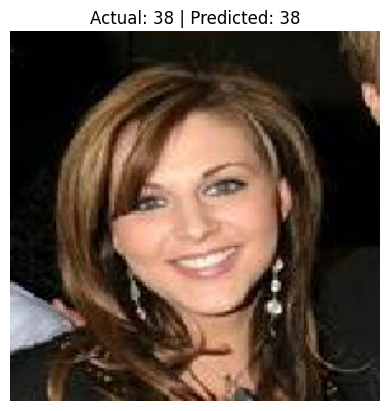

In [ ]:
import random
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
import numpy as np
class_names_list = train_df_split['label_'].unique()
print("Available classes:", class_names_list)

selected_class ='38'

img_paths = train_df_split[train_df_split['label_'] == selected_class]['image_path'].tolist()
img_path = random.choice(img_paths)
print("Selected image path:", img_path)
img = image.load_img(img_path, target_size=(224,224))
img_array = image.img_to_array(img)
img_array_exp = np.expand_dims(img_array, axis=0)
img_array_exp = preprocess_input(img_array_exp)

pred = model.predict(img_array_exp)
pred_class_idx = np.argmax(pred, axis=1)[0]

class_names = {v: k for k,v in train_generator.class_indices.items()}

import numpy as np

plt.imshow(np.array(img).astype('uint8'))
plt.axis('off')
plt.title(f"Actual: {selected_class} | Predicted: {class_names[pred_class_idx]}")
plt.show()


Saving 694fb730-da9f-4446-ad2f-4ed7ac700676.jpg to 694fb730-da9f-4446-ad2f-4ed7ac700676.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


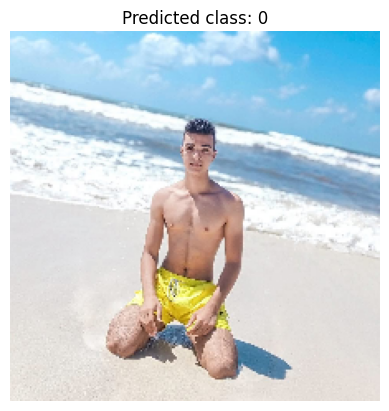

In [ ]:
from google.colab import files
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
import numpy as np
import matplotlib.pyplot as plt
uploaded = files.upload()
img_path = list(uploaded.keys())[0]
img = image.load_img(img_path, target_size=(224,224))
img_array = image.img_to_array(img)
img_array_exp = np.expand_dims(img_array, axis=0)
img_array_exp = preprocess_input(img_array_exp)
pred = model.predict(img_array_exp)
pred_class_idx = np.argmax(pred, axis=1)[0]
class_names_list = sorted(train_df_split['label_'].unique())
class_names = {i: name for i, name in enumerate(class_names_list)}
plt.imshow(np.array(img).astype('uint8'))
plt.axis('off')
plt.title(f"Predicted class: {class_names[pred_class_idx]}")
plt.show()

In [ ]:
def predict_top_k(image_path, model, class_idx, k=3):
    from tensorflow.keras.preprocessing.image import load_img, img_to_array
    from tensorflow.keras.applications.vgg16 import preprocess_input
    import numpy as np

    img = load_img(image_path, target_size=(224,224))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    pred = model.predict(img_array)[0]

    top_indices = pred.argsort()[-k:][::-1]

    inv_class_idx = {v:k for k,v in class_idx.items()}

    top_predictions = [(inv_class_idx[i], pred[i]) for i in top_indices]

    return top_predictions


In [ ]:
from google.colab import files

uploaded = files.upload()

image_path = list(uploaded.keys())[0]
print("Image uploaded:", image_path)


Saving 40a265a7-fa7a-4966-bd32-8910d8e74e25.jpg to 40a265a7-fa7a-4966-bd32-8910d8e74e25 (4).jpg
Image uploaded: 40a265a7-fa7a-4966-bd32-8910d8e74e25 (4).jpg


In [ ]:
top_preds = predict_top_k(image_path, model, class_idx, k=3)
print("Top 3 predictions with probabilities:")
for label, prob in top_preds:
    print(f"{label}: {prob*100:.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Top 3 predictions with probabilities:
n000069: 93.04%
n000038: 2.60%
1Mohmad-Ayman-Suleiman: 1.86%


In [ ]:
model.save("meena_V1_c50_s50_acc93.h5")